In [ ]:
import os
import csv
import cv2
from skimage import io
import numpy as np
from skimage.measure import block_reduce, label, regionprops
from skimage.color import label2rgb
import tifffile as tiff
import matplotlib.pyplot as plt
from nd2 import ND2File
from pathlib import Path
from skimage.morphology import remove_small_objects
from skimage.segmentation import clear_border
from skimage import filters
from scipy import ndimage

from scipy.spatial import cKDTree

import pandas as pd
from matplotlib.patches import Circle

from sklearn.metrics.pairwise import paired_distances

In [ ]:
from typing import Optional
import warnings

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage


__all__ = [
    "apply_gaussian_filter",
    "remove_baseline",
    "binarize",
]


def apply_gaussian_filter(
    img: np.ndarray, sigma: int, radius: Optional[int] = None, debug: bool = False
) -> tuple[np.ndarray, np.ndarray]:
    """applies a 2D highpass filter to remove baseline drift and detect edges, or to blur image

    Parameters:
    ----------
    img: image

    sigma: sigma for gaussian kernel

    radius: Optional radius for gaussian kernel

    debug: whether to display figures intended for development

    Returns:
    -------
    lowpass filtered image, highpass filtered image
    """
    # normalize and discretize pixel intensities
    img = img.copy().astype(np.float64)
    img -= np.min(img.flatten())
    img *= 256 / np.max(img.flatten())
    img = np.round(img, 0).astype(np.int64)

    # filter image
    gauss_lowpass = ndimage.gaussian_filter(img, sigma, radius=radius)
    gauss_highpass = np.array(img, dtype=np.int64) - np.array(
        gauss_lowpass, dtype=np.int64
    )
    min_highpass = np.min(np.min(gauss_highpass))
    if min_highpass < 0:
        gauss_highpass -= min_highpass

    if debug:
        # gauss_highpass = np.max(np.max(gauss_highpass)) - gauss_highpass
        print(f"original range: ({np.min(np.min(img))}, {np.max(np.max(img))})")
        print(
            f"lowpass range:  ({np.min(np.min(gauss_lowpass))}, {np.max(np.max(gauss_lowpass))})"
        )
        print(
            f"highpass range: ({np.min(np.min(gauss_highpass))}, {np.max(np.max(gauss_highpass))})"
        )

        fig0 = plt.figure()
        ax0 = plt.gca()
        fig0.suptitle("Original")
        ax0.imshow(img, cmap="gray")

        fig1 = plt.figure()
        ax1 = plt.gca()
        fig1.suptitle("Lowpass")
        ax1.imshow(gauss_lowpass, cmap="gray")

        fig2 = plt.figure()
        ax2 = plt.gca()
        fig2.suptitle("Highpass")
        ax2.imshow(gauss_highpass, cmap="gray")

        plt.show()
        plt.close()

    return (gauss_lowpass, gauss_highpass)


def remove_baseline(img: np.ndarray, factor: int | float = 4) -> np.ndarray:
    """uses a highpass filter to remove baseline"""
    dim = min([*np.shape(img)])
    baseline, no_baseline = apply_gaussian_filter(img, sigma=int(np.ceil(dim / factor)))

    return no_baseline


def remove_baseline_DEBUGGING(img: np.ndarray, factor: int | float = 4) -> np.ndarray:
    """uses a highpass filter to remove baseline"""
    dim = min([*np.shape(img)])
    import matplotlib.pyplot as plt

    factors = 5 * np.logspace(0, 2, num=5, endpoint=True, base=10)
    for f in [*factors, 128]:
        baseline, no_baseline = apply_gaussian_filter(img, sigma=int(f), debug=False)
        fig, ax = plt.subplots(1, 3)
        fig.suptitle(f"{f}\n{np.min(no_baseline):.3f}, {np.max(no_baseline):.3f}")
        ax[0].imshow(img)
        ax[1].imshow(baseline)
        ax[2].imshow(no_baseline)

    plt.show()

    import sys

    sys.exit()

    return no_baseline


def binarize(
    highpass_img: np.ndarray,
    opt_thresh: bool = False,
    thresh: int | float = 0.5,
    show_hist: bool = False,
) -> np.ndarray:
    """masks image

    Parameters:
        img: should be highpass-filtered to remove baseline and enhance edges
        opt_thresh: whether the program should decide the optimal pixel intensity threshold
        thresh: float between 0 and 1. Sets threshold for binarizing image
        show_hist: for development only. shows histogram of intensities

    Returns:
        binarized image of same dimensions

    Raises:
        ValueError if thresh is out of range
    """
    if 0 > thresh or thresh > 1:
        raise ValueError(f"thresh must be between 0 and 1. Received value of {thresh}")

    max_val = int(np.max(np.max(highpass_img)))
    min_val = int(np.min(np.min(highpass_img)))
    thresh_val = thresh * max_val + (1 - thresh) * min_val

    if opt_thresh:
        try:
            hist, bins = np.histogram(
                highpass_img.flatten(),
                bins=round(max_val - min_val + 1),
            )
            peak = np.argmax(hist)
            hist_high = hist[peak:]
            bins_high = bins[peak:-1]
            thresh_val = np.min(bins_high[hist_high < 0.5 * hist[peak]])
            # thresh_val = bins_high[np.argmin(np.diff(hist_high))]
        except:
            warnings.warn(
                "Unable to use optimal threshold. Using default threshold.",
                category=UserWarning,
            )

    if show_hist:
        plt.figure()
        plt.title("Pixel Intensities")
        plt.hist(highpass_img.copy().flatten(), bins=100)
        plt.axvline(thresh_val, color="r")
        plt.show()
        plt.close()

    bin_img = np.zeros_like(highpass_img, dtype=np.int64)
    bin_img[highpass_img > thresh_val] = 1

    return bin_img

In [ ]:
from math import sqrt

import numpy as np

# from reader import nd2_img_reader, get_stain
# from .filters import (
#     apply_gaussian_filter,
#     remove_baseline,
#     binarize,
#     remove_baseline_DEBUGGING,
# )



def mask_img(img: np.ndarray, **kwargs) -> tuple[np.ndarray, np.ndarray]:
    """Masks image

    Parameters:
    ----------
    img: np.ndarray of image (N x M)

    bin_thresh: intensity threshold to binarize image (range: 0-1, default = 0.1)

    filter_coeff: coefficient to filter image. Smaller numbers remove baseline more effectively (default = 4)


    Returns:
    -------
    masked image containing filtered values within cell bounds

    mask used for this calculation
    """
    params = {
        "bin_thresh": 0.1,
        "filter_coeff": 4,
        "opt_thresh": False,
    }
    params.update(kwargs)

    filtered = remove_baseline(img, params["filter_coeff"])
    mask = binarize(
        filtered, opt_thresh=params["opt_thresh"], thresh=params["bin_thresh"]
    )

    masked_img = mask * filtered

    values = masked_img.copy().flatten()
    nonzero = values[values > 0]
    shift = mask * float(np.min(nonzero)) if (len(nonzero) > 0) else 0
    masked_img_shifted = masked_img - shift

    return (masked_img_shifted, mask)


def highlight_mask_edges(mask: np.ndarray) -> np.ndarray:
    """uses gaussian filter to highlight edges"""
    centers, edges = apply_gaussian_filter(mask, sigma=1, radius=2)
    edges_bin = np.zeros_like(edges, dtype=np.int64)
    edges_bin[edges > 0.5] = 1

    return edges_bin



def preprocess_image(
    img: np.ndarray, filter_coeff: int, bin_thresh: float = 0.1, opt_thresh: bool = False
) -> tuple[np.ndarray, ...]:
    """Preprocesses images

    Arguments:
        img: DAPI-stained microscopy image

    Results:
        preprocessed image,
        mask,
        mask_edges,
    """
    # normalize
    norm_img = img.copy().astype(np.float64)
    norm_img -= np.min(norm_img.flatten())
    norm_img /= np.max(norm_img.flatten())

    # develop masks
    masked_img, mask = mask_img(
        norm_img, bin_thresh=bin_thresh, filter_coeff=filter_coeff, opt_thresh=opt_thresh
    )
    #mask_edges = highlight_mask_edges(mask)

    return (masked_img, mask)#, mask_edges)

In [ ]:
def gather_image_paths_in_subfolders(root_path):
    """
    Recursively finds all .tif/.tiff files in `root_path` and returns a list of full file paths.
    """
    image_files = []
    for current_dir, subdirs, files in os.walk(root_path):
        for file in files:
            if file.lower().endswith('.tif') or file.lower().endswith('.tiff'):
                image_files.append(os.path.join(current_dir, file))
    return image_files

In [ ]:
def compute_batch_channel_stats(all_image_paths, channels=4, lower_percentile=0.05, upper_percentile=99.95):
    """
    Collect pixel values across all images (in raw space),
    compute global min/max (percentiles) for each channel.
    Returns min_vals[ch], max_vals[ch].
    """
    all_channel_data = [[] for _ in range(channels)]

    for path in all_image_paths:
        im = tiff.imread(path).astype('float32')
        # Move channel axis -> shape: (H, W, channels)
        im = np.moveaxis(im, 0, -1)

        for ch_idx in range(channels):
            all_channel_data[ch_idx].extend(im[:, :, ch_idx].ravel())

    min_vals = []
    max_vals = []
    for ch_idx in range(channels):
        ch_data = np.array(all_channel_data[ch_idx])
        lower_val = np.percentile(ch_data, lower_percentile)
        upper_val = np.percentile(ch_data, upper_percentile)
        min_vals.append(lower_val)
        max_vals.append(upper_val)

    return min_vals, max_vals

In [ ]:
def load_and_normalise_image(image_path, min_vals, max_vals):
    """
    Loads image from path, downsamples by 2, and uses global (min_vals, max_vals)
    to normalise each channel to [0, 1].
    """
    # Load raw
    image = tiff.imread(image_path).astype('float32')
    image = np.moveaxis(image, 0, -1)  # shape: (H, W, 4)

    # Downsample
    image = block_reduce(image, block_size=(2, 2, 1))

    # Normalise each channel to [0,1] using global min/max
    for ch_idx in range(len(min_vals)):
        image[:, :, ch_idx] = np.clip(image[:, :, ch_idx], min_vals[ch_idx], max_vals[ch_idx])
        denom = max_vals[ch_idx] - min_vals[ch_idx]
        if denom > 0:
            image[:, :, ch_idx] = (image[:, :, ch_idx] - min_vals[ch_idx]) / denom
        else:
            raise ValueError(f"Error: min and max are the same for channel {ch_idx}")
    
    return image

In [ ]:
def gather_normalised_mito_and_sc_pixels(all_image_paths, min_vals, max_vals,
                                         mito_channel_idx=2, sc_channel_idx=3):
    """
    1) Loads each image, normalises it using the global min_vals/max_vals.
    2) Extracts the (normalised) pixels from the mitochondria channel and 2SC channel.
    3) Returns two big lists: all_mito_pixels_norm, all_sc_pixels_norm.
    """
    all_mito_pixels_norm = []
    all_sc_pixels_norm = []

    for path in all_image_paths:
        # Load + normalise
        norm_image = load_and_normalise_image(path, min_vals, max_vals)
        # Extract channels
        mito_pixels = norm_image[:, :, mito_channel_idx].ravel()
        sc_pixels = norm_image[:, :, sc_channel_idx].ravel()
        all_mito_pixels_norm.extend(mito_pixels)
        all_sc_pixels_norm.extend(sc_pixels)
    
    return all_mito_pixels_norm, all_sc_pixels_norm

In [ ]:
def compute_global_thresholds_in_normalised_space(mito_pixels_norm,
                                                  mito_percentile=95):
    """
    Given two lists of normalised intensities, one for mitochondria channel and
    one for 2SC channel, compute global threshold (e.g. 90th percentile) in normalised space.
    """
    mito_pixels_norm = np.array(mito_pixels_norm)

    global_mito_threshold = np.percentile(mito_pixels_norm, mito_percentile)

    return global_mito_threshold

In [ ]:
def overlay_segmentation_with_mito_in_microglia(image, cytoplasm_mask, nucleus_mask, mito_mask, sc_mask):
    grayscale_background = np.mean(image[:, :, :3], axis=2)
    overlay = np.stack([grayscale_background]*3, axis=-1).astype(np.uint8)
    
    cytoplasm_color = [0, 255, 0]  # Green
    nucleus_color = [255, 0, 255]  # Magenta
    mito_color = [0, 0, 255]       # Blue
    sc_color = [255, 0, 0]         # Red

    mito_mask_cyto = np.logical_and(mito_mask, cytoplasm_mask)
    sc_mask_cyto = np.logical_and(sc_mask, cytoplasm_mask)
    
    overlay[cytoplasm_mask > 0] = cytoplasm_color
    overlay[nucleus_mask > 0] = nucleus_color
    overlay[mito_mask_cyto > 0] = mito_color
    overlay[sc_mask_cyto > 0] = sc_color
    
    return overlay

In [ ]:
def nd2_to_tif(path, file_name):
    nd2_path = Path(path) / file_name
    tif_path = nd2_path.with_suffix(".tif")

    with ND2File(nd2_path) as nd2_file:
        nd2_data = nd2_file.asarray()
        tiff.imwrite(tif_path, nd2_data)

### Start code

In [ ]:
all_prop = pd.read_csv("/Users/nelsschimek/Downloads/All_Properties.csv")
all_prop.head()

In [175]:
directory = Path('/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b')

# Get all .nd2 files
nd2_files = list(directory.glob("*.nd2"))

# If you want full paths as strings:
nd2_file_paths = [str(f) for f in nd2_files]

In [176]:
matt_masks = Path("/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b")
npy_files = list(matt_masks.glob("*.npy"))

npy_file_paths = [str(f) for f in npy_files]

In [177]:
for file in nd2_files:

    nd2_to_tif(directory, file)

# Get all .nd2 files
tif_files = list(directory.glob("*.tif"))

# If you want full paths as strings:
tif_file_paths = [str(f) for f in tif_files]

In [178]:
tif_file_paths[0].split("/")[-1]

'060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_F_40x_hp_2.tif'

In [179]:
images = [tiff.imread(f) for f in tif_file_paths]
print(len(images))

npy_masks = [np.load(f) for f in npy_file_paths]
len(npy_masks)

42


42

In [180]:
print(sorted(tif_file_paths))

['/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_D_40x_ctx_1.tif', '/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_D_40x_ctx_2.tif', '/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_D_40x_ctx_3.tif', '/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_D_40x_ctx_4.tif', '/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_D_40x_ctx_5.tif', '/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_D_40x_mb_

In [181]:
print(sorted(npy_file_paths))

['/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_D_40x_ctx_1.npy', '/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_D_40x_ctx_2.npy', '/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_D_40x_ctx_3.npy', '/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_D_40x_ctx_4.npy', '/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_D_40x_ctx_5.npy', '/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_D_40x_mb_

In [171]:
first_mask = np.load("/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_F_40x_ctx_7.npy")

In [172]:
first_tif_idx = tif_file_paths.index("/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/ORST/cd11b/060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_F_40x_ctx_7.tif")

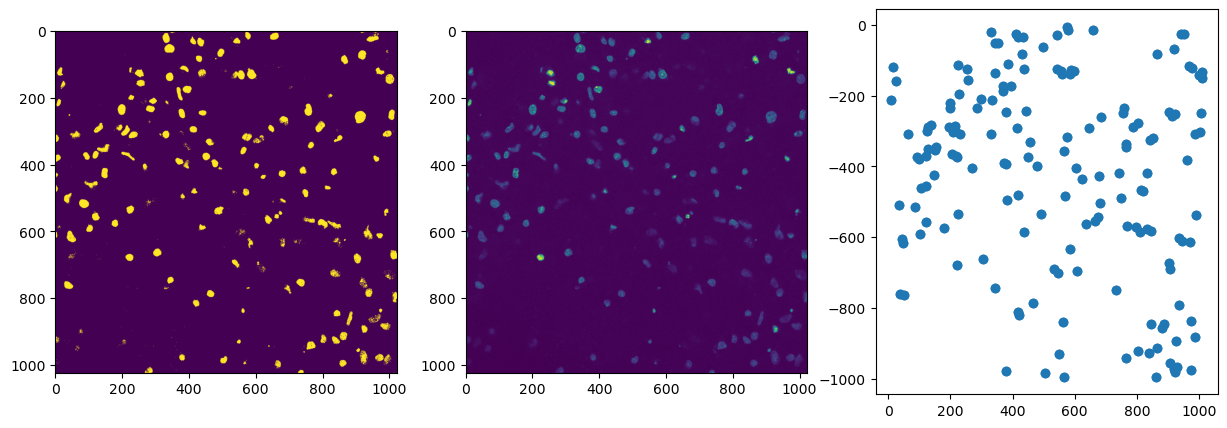

In [173]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(first_mask[1])
ax[1].imshow(images[first_tif_idx][0,:,:])

test_file = all_prop[all_prop["file_name"] == "060225_P10F_4DIV_OR10_G11_ORST_F24h_CD11B_MT_DAPI_Slice_F_40x_ctx_7"]
ax[2].scatter(test_file["j"]*2, -test_file["i"]*2)


In [ ]:
fig, axes = plt.subplots(len(npy_masks[0:20]), 2, figsize=(16,80))

for ax, matt_im, nels_im in zip(axes, tif_file_paths, matt_masks):

    mask_overlay = create_overlay(matt_im[1], (create_nuclei_mask((nels_im[0]))))
    mask_overlay_alt = create_overlay(matt_im[1], (nels_im[0]))

    ax[0].imshow(mask_overlay)
    ax[1].imshow((mask_overlay_alt))



plt.tight_layout()
plt.show()
    

In [ ]:
#min_vals, max_vals = compute_batch_channel_stats(tif_file_paths, channels=3)

In [ ]:
# normalized_images = []

# for image in tif_file_paths:
#     norm_im = load_and_normalise_image(image, min_vals, max_vals)
#     normalized_images.append(norm_im[:,:,2])

In [ ]:
#plt.hist(images[14][2,:,:].flatten())

In [ ]:
# # Create subplots
# n = len(tif_files)
# fig, axes = plt.subplots(n, 2, figsize=(10,n*4))  

# # If there's only one image, axes won't be iterable
# if n == 1:
#     axes = [axes]

# for ax, img, path in zip(axes, images, images):

#     perc = np.percentile(img[1,:,:], 99)
#     ax[0].imshow(remove_small_objects(img[2,:,:]>perc, min_size=10), cmap="gray")
#     ax[1].imshow(path[2,:,:,], cmap="gray") #why?
#     #ax.set_title(path)
#     #ax.axis("off")

# plt.tight_layout()
# plt.show()

### Microglia

In [ ]:
# thresh_li = filters.threshold_li(images[0][1,:,:])
# binary_li = images[0][1,:,:] > thresh_li

# #Remove small objects and fill holes
# binary_li = remove_small_objects(
#     binary_li, min_size=70
#     )
# binary_li = ndimage.binary_fill_holes(binary_li)

In [ ]:
# # Create subplots
# n = len(images)
# fig, axes = plt.subplots(n, 1, figsize=(20,60))  

# # If there's only one image, axes won't be iterable
# if n == 1:
#     axes = [axes]

# for ax, img, path in zip(axes, images, images):

#     img = img[1,:,:]


#     #img = ((img- img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
#     # super_threshold_indices = img < 5
#     # img[super_threshold_indices] = 0

#     thresh_li = filters.threshold_li(img)
#     binary_li = img > thresh_li

#     thresh_isodata = filters.threshold_isodata(img)
#     binary_isodata = img > thresh_isodata  

#     thresh_otsu = filters.threshold_otsu(img)
#     binary_otsu = img > thresh_otsu

#     thresh_triangle = filters.threshold_triangle(img)
#     binary_triangle = img > thresh_triangle

#     max_num_pixels = 800 / ((0.4315837)*(0.4318837))

#     objects = label(binary_li)
#     large_objects = remove_small_objects(objects, min_size=8590)
#     small_objects = label((objects ^ large_objects) > thresh_li)

#     scaled_img = ((img- img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
#     scaled_thresh_li = filters.threshold_li(scaled_img)
#     scaled_binary_li = scaled_img > scaled_thresh_li

#     hist = np.histogram(scaled_img.flatten(), range=[0,50], bins=50)

#     #if hist[0][0] > (hist[0][1] + hist[0][2]):

#     ax.imshow(remove_small_objects(img), cmap="gray") #why?
#     # ax[1].imshow(ndimage.binary_fill_holes(remove_small_objects(binary_li, min_size=71)), cmap="gray")
#     # ax[2].imshow(ndimage.binary_fill_holes(remove_small_objects(binary_isodata, min_size=71)), cmap="gray")
#     # ax[3].imshow(ndimage.binary_fill_holes(remove_small_objects(binary_otsu, min_size=71)), cmap="gray")
#     # ax[4].imshow(ndimage.binary_fill_holes(remove_small_objects(binary_triangle, min_size=71)), cmap="gray")
#     #ax[2].imshow(ndimage.binary_fill_holes(remove_small_objects(small_objects > thresh_li, min_size=71)), cmap="gray")
#     #ax[3].hist((scaled_img).flatten(), range=[0,50], bins=50)

#     #else:
#         #print(f'{hist[0][0]}, {(hist[0][1] + hist[0][2])}')

    
#     #ax.set_title(path)
#     #ax.axis("off")

# plt.tight_layout()
# plt.show()

In [ ]:
# hist = np.histogram(scaled_img.flatten(), range=[0,50], bins=50)
# hist[0][0]

In [ ]:
# # Create subplots
# n = len(images)
# fig, axes = plt.subplots(n, 2, figsize=(20, 50))  

# # If there's only one image, axes won't be iterable
# if n == 1:
#     axes = [axes]

# for ax, img, path in zip(axes, images, images):

#     img = img[1,:,:]


#     scaled_img = ((img- img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
    



#     ax[0].imshow((scaled_img), cmap="gray") 
#     ax[1].hist((scaled_img).flatten(), range=[0,50], bins=50)

# plt.tight_layout()
# plt.show()

### Overlay

In [ ]:
def create_microglia_mask(image, threshold_methold=filters.threshold_li):

    thresh_li = threshold_methold(image)
    binary_li = image > thresh_li
    binary_li = remove_small_objects(binary_li, min_size=100)
    binary_li = ndimage.binary_fill_holes(binary_li)
    return binary_li

def create_mitochondria_mask(image, percentile=99, min_size=10):

    perc = np.percentile(image, percentile)
    mito_mask = remove_small_objects(image>perc, min_size=min_size)
    return mito_mask

def create_nuclei_mask(image):
    
    thresh_li = filters.threshold_li(image)
    binary_li = image > thresh_li
    nuclei_mask = remove_small_objects(binary_li)
    nuclei_mask = ndimage.binary_fill_holes(nuclei_mask)
    return nuclei_mask

def create_matt_mask(image):
    thresh_li = filters.threshold_li(image)
    binary_li = image > thresh_li
    nuclei_mask = remove_small_objects(image)
    nuclei_mask = ndimage.binary_fill_holes(nuclei_mask)
    return nuclei_mask

In [ ]:
str(directory)

In [ ]:
mito_masks = []
#microg_masks = []
nuclei_masks = []

for image in images:

    mito_masks.append(create_mitochondria_mask(image[2,:,:]))
    #microg_masks.append(create_microglia_mask(image[1,:,:]))
    nuclei_masks.append(create_nuclei_mask(image[0,:,:]))

In [ ]:
#grayscale_background = np.mean(images[0][:3, :, :], axis=2)
#overlay = np.stack([grayscale_background]*3, axis=-1).astype(np.uint8)

def create_overlay(mito_mask, microglia_mask):

    overlay = np.zeros([mito_mask.shape[0],mito_mask.shape[1], 3])
    #nuclei_color = [255, 0, 0]
    microglia_color = [0, 0, 255]  # Green
    mito_color = [255, 0, 255]  # Magenta


    #mito_mask_microglia = np.logical_and(mito_masks, microglia_mask)

    overlay[microglia_mask > 0] = microglia_color
    overlay[mito_mask > 0] = mito_color
    return overlay

In [ ]:
# Create subplots
# n = len(nuclei_masks)
# fig, axes = plt.subplots(n, 1, figsize=(10,n*4))

# for i in range(n):

#     axes[i].imshow(create_overlay(mito_masks[i], nuclei_masks[i])/255.0)

#     image_name = str(tif_file_paths[i]).split("/")[-1]
#     key_end = image_name.split("_")
#     title = f'{key_end[-5]}_{key_end[-4]}_{key_end[-3]}_{key_end[-2]}_{key_end[-1]}'
#     axes[i].title.set_text(title)

# plt.tight_layout()

In [ ]:
def get_distance_dictionary(file_name, X_props, Y_props, max_distance, nuclei_count=0):

    

    df = pd.DataFrame()

    # Precompute all nuclei centroids
    nuclei_centroids = np.array([obj.centroid for obj in X_props])
    nuclei_labels = [obj.label for obj in X_props]
    nuclei_radii = np.sqrt(np.array([obj.area for obj in X_props]) / np.pi)


    distance_dict = {}

    # Build KDTree once
    tree = cKDTree(nuclei_centroids)

    
    # For each mito centroid, query the closest nucleus
    for mito_object in Y_props:
        mito_centroid = np.array(mito_object.centroid)
        mito_radius = np.sqrt(mito_object.area)/np.pi
        
        dist, idx = tree.query(mito_centroid)
        closest_label = nuclei_labels[idx]
        closest_centroid = nuclei_centroids[idx]
        closest_radii = nuclei_radii[idx]
        

        if dist < max_distance or dist == max_distance:

            if closest_label in distance_dict.keys():
                distance_dict[closest_label].append([closest_label, dist, closest_centroid, mito_centroid])
            else: 
                distance_dict[closest_label] = [closest_label, dist, closest_centroid, mito_centroid]

    

        new_row = pd.DataFrame(
                {'filename': [file_name.split("/")[-1]],
                'nuclei': [closest_label + nuclei_count],
                'centroid_distance': [dist], 
                'nuclei_ideal_radius': [closest_radii],
                'nuc_centroid_x': [closest_centroid[0]], 
                'nuc_centroid_y': [closest_centroid[1]], 
                'mito_ideal_radius': [mito_radius],
                'mito_centroid_x': [mito_centroid[0]],
                'mito_centroid_y': [mito_centroid[1]],
                'total_nuclei': [len(X_props)],
                'total_mito_objects': [len(Y_props)]}
            )
        df = pd.concat([df, new_row], ignore_index=True)
    
    return distance_dict, df

In [ ]:
distances = []
dfs = pd.DataFrame()
nuclei_count = 0
for i in range(len(nuclei_masks)):
    X = label(nuclei_masks[i])
    Y = label(mito_masks[i])
    X_props = regionprops(X)
    Y_props = regionprops(Y)

    cur_distance_dict, cur_df = get_distance_dictionary(file_name=tif_file_paths[i], X_props=X_props, Y_props=Y_props, max_distance=4.7, nuclei_count=nuclei_count)
    distances.append(cur_distance_dict)
    dfs = pd.concat([dfs, cur_df], ignore_index=True)
    nuclei_count = len(dfs)

In [ ]:
title = str(directory).split("/")
treatment_condition = f"{title[-2]}_{title[-1]}"
dfs['treatment_condition'] = treatment_condition
dfs.to_csv(f'{title[-2]}_Nuclei_Mito_distances_{title[-1]}.csv')

In [ ]:
# def plot_distances(distance_dict_list):

#     plt.figure(figsize=(4, 4))

#     for key, value in distance_dict.items():
#         # Process the primary vector
#         if isinstance(value[2], np.ndarray) and isinstance(value[3], np.ndarray):
#             start = value[2]
#             end = value[3]
#             dx = end[0] - start[0]
#             dy = end[1] - start[1]
#             plt.arrow(start[0], start[1], dx, dy, head_width=3, head_length=3, fc='blue', ec='blue')
#             plt.plot(start[0], start[1], 'g.')  # Start point
#             plt.plot(end[0], end[1], 'r.')      # End point
#             #plt.text(start[0], start[1], str(key), fontsize=8, color='black')

#         # Process sub-vectors (if any)
#         for sub in value[4:]:
#             if isinstance(sub, list) and len(sub) >= 4:
#                 sub_start = sub[2]
#                 sub_end = sub[3]
#                 dx = sub_end[0] - sub_start[0]
#                 dy = sub_end[1] - sub_start[1]
#                 plt.arrow(sub_start[0], sub_start[1], dx, dy, head_width=3, head_length=3, fc='gray', ec='gray')
#                 plt.plot(sub_end[0], sub_end[1], 'r.')  # Smaller marker for sub-end

#     #plt.gca().invert_xaxis()  # Optional for image-style coordinates
#     #plt.gca().invert_yaxis()  # Optional for image-style coordinates
#     plt.axis('equal')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.title('All Centroid Vectors (Primary and Sublists)')
#     #plt.grid(True)
#     plt.show()

In [ ]:
def make_distance_plot(distance_dicts, max_distance=20, title=None):
    

    circle_one = Circle((max_distance, max_distance), 3, facecolor='none',
                        edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)
    circle_two = Circle((max_distance, max_distance), max_distance, facecolor='none',
                    edgecolor=(0, 0.2, 0.2), linewidth=3, alpha=0.5)
    fig, ax = plt.subplots(figsize=(4,4))
    ax.add_patch(circle_one)
    ax.add_patch(circle_two)
    
    for distance_dict in distance_dicts:

        

        for key, value in distance_dict.items():
            # Process the primary vector
            if isinstance(value[2], np.ndarray) and isinstance(value[3], np.ndarray):
                start = value[2]
                end = value[3]
                dx = end[0] - start[0]
                dy = end[1] - start[1]
                ax.arrow(max_distance, max_distance, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=0.1)
                #ax.plot(start[0], start[1], 'g.')  # Start point
                #ax.plot(end[0], end[1], 'r.')      # End point
                #ax.text(start[0], start[1], str(key), fontsize=8, color='black')

            # Process sub-vectors (if any)
            for sub in value[4:]:
                if isinstance(sub, list) and len(sub) >= 4:
                    sub_start = sub[2]
                    sub_end = sub[3]
                    dx = sub_end[0] - sub_start[0]
                    dy = sub_end[1] - sub_start[1]
                    ax.arrow(max_distance, max_distance, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=0.1)
                    #ax.plot(sub_end[0], sub_end[1], 'r.')  # Smaller marker for sub-end

    ax.set_xlim([0,(max_distance*2)])
    ax.set_ylim([0,(max_distance*2)])
    ax.set_title(title)
    plt.show()

In [ ]:
title = str(directory).split("/")
make_distance_plot(distance_dicts=distances, title=f'{title[-2]} Nuclei Mito distances {title[-1]} (2uM)', max_distance=5)

In [ ]:
mask_file = '/Users/nelsschimek/Documents/nancelab/Data/mito_images/brendan_full_analysis/tifs/HC/cd11b/li_thresh/060225_P10F_4DIV_OR10_control_HC_F24h_DAPI_CD11b_Blank_MT_Slice_A_40x_mb_3_li_thresh.npy'

In [ ]:
import skimage
from skimage.segmentation import clear_border

binary_mask = np.load(mask_file)

# Label connected regions in the binary mask
label_image = label(binary_mask)
cleaned_mask = clear_border(labels=label_image)

# Measure properties
props = skimage.measure.regionprops_table((label_image))

# Create a DataFrame for the current file
props_df = pd.DataFrame(props)

 

In [ ]:
plt.imshow(cleaned_mask, cmap="gray")